In [1]:
# common
import os
import glob
import datetime
import re
from matplotlib import pyplot as plt

# file converters
from pdf2image import convert_from_path

# cv
import cv2

# ocr
import pytesseract
from pytesseract import Output

# NER
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [2]:
class XToJPEG:
    def __init__(self):
        pass
    
    def convert(self, file_path, output_dir):
        file_type = file_path.rsplit('.', 1)[1]
        
        if file_type == 'pdf':
            return self.convert_pdf_to_image(file_path, output_dir)
        else:
            raise NotImplementedError(f'Unknown type {file_type} in XToJPEG')
    
    def convert_pdf_to_image(self, file_path, output_dir):
        images = convert_from_path(file_path)

        for i in range(len(images)):   
            images[i].save(os.path.join(output_dir, f'page{i}.jpg'), 'JPEG')

In [3]:
class OCR:
    def __init__(self):
        self.config = r'--oem 3 -l rus -c --tessdata-dir=/usr/local/share/tessdata/'
    
    def process(self, img):
        d = pytesseract.image_to_data(img, output_type=Output.DICT, config=self.config)
        return d

In [4]:
class PersonExtractor:
    def __init__(self):
        self.segmenter = Segmenter()
        self.morph_vocab = MorphVocab()

        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)
        self.syntax_parser = NewsSyntaxParser(self.emb)
        self.ner_tagger = NewsNERTagger(self.emb)

        self.names_extractor = NamesExtractor(self.morph_vocab)
        
    def get_persons(self, text):
        doc = Doc(text)

        doc.segment(self.segmenter)
        doc.tag_morph(self.morph_tagger)
        
        for token in doc.tokens:
            token.lemmatize(self.morph_vocab)
            
        doc.parse_syntax(self.syntax_parser)
        doc.tag_ner(self.ner_tagger)
        
        for span in doc.spans:
            span.normalize(self.morph_vocab)
            if span.type == PER:
                span.extract_fact(self.names_extractor)

        return [(_.normal,  _.fact.as_dict, (_.start, _.stop))
                for _ in doc.spans if _.type == PER and _.fact]

In [5]:
class Runner:
    def __init__(self):
        self.jpeg_converter = XToJPEG()
        self.ocr = OCR()
        self.person_extractor = PersonExtractor()

    def process(self, input_file_path, ouput_dir_path):
        
        # convert input file to jpeg
        self.jpeg_converter.convert(input_file_path, ouput_dir_path)
        
        # iterate over jpegs (1 jpg - 1 page in file)
        for file in os.listdir(ouput_dir_path):
            file_path = os.path.join(ouput_dir_path, file)
            
            # read image
            img = cv2.imread(file_path)
            
            # get OCR results
            ocr_result = self.ocr.process(file_path)

            # combine texts together
            text_combined_position2box_number = {}
            text_combined = ''
            curr_position = 0
            hyphenation_primitive_criterion = False

            for i, text in enumerate(ocr_result['text']):
                if text != '':        
                    if not hyphenation_primitive_criterion:
                        # we add space between words 
                        text_combined += ' '
                        curr_position += 1

                    # if prev word was on previos line we shell delete leading spaces for next word
                    if hyphenation_primitive_criterion:
                        text = text.lstrip()
                        hyphenation_primitive_criterion = False

                    if re.findall('[^\d][ ]*-[ ]*', text):
                        text = re.sub('[ ]*-[ ]*', '', text)
                        hyphenation_primitive_criterion = True

                    for j in range(len(text)):
                        text_combined_position2box_number[curr_position+j] = i
                    text_combined += text
                    curr_position += len(text)

            # get PER from combined text
            persons = self.person_extractor.get_persons(text_combined)

            # find out which boxes around text we should mark
            boxes_num_to_show = set() 
            for _, _, (i, j) in persons:
                for k in range(i, j+1):
                    if k in text_combined_position2box_number:
                        boxes_num_to_show.add(text_combined_position2box_number[k])

            # iterate over boxes and mark PER with red, other with green
            n_boxes = len(ocr_result['text'])
            for i in range(n_boxes):
                if int(ocr_result['conf'][i]) > 0: # TODO check threshold
                    (x, y, w, h) = (ocr_result['left'][i], 
                                    ocr_result['top'][i], 
                                    ocr_result['width'][i], 
                                    ocr_result['height'][i])

                    if i in boxes_num_to_show:
                        c = (0, 0, 255)
                    else:
                        c = (0, 255, 0)

                    img = cv2.rectangle(img, (x, y), (x + w, y + h), c, 2)


            # save reult in the same dir
            output_file = os.path.join(ouput_dir_path, f'{file.rsplit(".", 1)[0]}_res.jpg')
            cv2.imwrite(output_file, img)

In [6]:
DATASET_PATH = '../data/dataset/'

all_files_paths = [
    x for x in glob.iglob(DATASET_PATH + '**', recursive=True)
    if os.path.isfile(x)
]

WORK_DIR = f'../data/result_{datetime.datetime.now().strftime("%d%m%Y_%H%m%s")}'
os.mkdir(WORK_DIR)

In [7]:
file_path = '../data/dataset/7/upload_21.12.2012_a-1057_2.pdf'
output_dir = os.path.join(WORK_DIR, file_path.rsplit('/', 1)[1].rsplit('.', 1)[0])
os.mkdir(output_dir)

runner = Runner()
runner.process(file_path, output_dir)

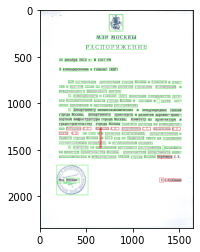

In [8]:
image = cv2.imread(output_dir+'/page0_res.jpg')
image = image[:,:,::-1]
plt.imshow(image)

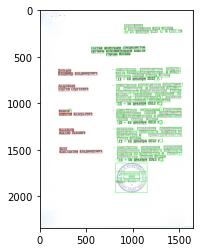

In [9]:
image = cv2.imread(output_dir+'/page1_res.jpg')
image = image[:,:,::-1]
plt.imshow(image)